# Shelter Animal Outcomes Classification

### 팀이름 : 동물 사랑 2조
### 팀원 : 박민수, 신민규, 전유진, 홍창휘

***

# [ 목 차 ]
## 1. 개요
### 1.1 수행과제 선정
### 1.2 문제정의
### 1.3 종속변수 설정
### 1.4 이슈 및 해결과정
### 1.5 최종모델
## 2. 문제해결 과정
### 2.0 패키지 임포트 및 함수정의
### 2.1 솔루션 1
### 2.2 솔루션 2
### 2.3 솔루션 3
### 2.4 솔루션 4
### 2.5 솔루션 5
## 3. 결론

***

# 1. 개요

## 1.1 수행과제 선정
- Contents 주제 : **'Shelter Animal Outcomes'** on kaggle competition
   * URL : https://www.kaggle.com/c/shelter-animal-outcomes
        
- Contents 목적 : 동물보호센터 내 유기동물 데이터로부터 특정 유기동물에 대한 최종 처분결과가 어떻게 되었는지 예측

## 1.2 문제 정의
- Austin Animal Center 에서 보호하게 되는 동물들 중, 새로운 보금자리를 찾아 주기 위해 센터에서 더욱 신경 써야하는 동물들 선별

## 1.3 종속변수 설정

- 동물들은 동물 보호 센터에서 5가지 유형(Outcome)으로 처리
    - Adoption
    - Return_to_owner
    - Transfer
    - Died
    - Euthanasia
- 보금자리를 찾아주기 위해 더욱 신경을 써야하는 동물들을 2가지 유형(Outcome)으로 설정
    - Died
    - Euthanasia

## 1.4 이슈 및 해결과정

**Issue 1)** 주어진 데이터의 일부가 Outcome 당시 데이터임을 파악  
**=>** 주어진 Outcome 데이터 중 Intake 당시에도 알 수 있는 Feature만 선택

**Issue 2)** 설명력 있는 변수가 부족    
**=>** Intake 당시의 데이터와 Merge

**Issue 3)** Test 데이터의 Merge 결과가 부정확  
**=>** Merge한 Train 데이터 내에서 Test 데이터를 별도로 분리

**Issue 4)** 저조한 Recall  
**=>** Imbalancing 처리

## 1.5 최종 모델

#### Recall Unweighted Mean : 0.775

![image](https://user-images.githubusercontent.com/44221498/50810946-85399b80-134f-11e9-9f44-1fe57bc8e7e9.png)


***

# 2. 문제해결 과정

## 2.0 패키지 임포트 및  함수정의

### 2.0.1 Packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import validation_curve, GridSearchCV
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import lightgbm

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### 2.0.2 Functions

In [2]:
# DataFrame의 컬럼 데이터 타입 변환 함수
def trans_type(df, columns, _type):
    for column in columns:
        df[column] = df[column].astype(_type)

# Series 내의 특정 문자열 치환
def replace_series_str(series, cond, old, new):
    series[series.str.contains(cond)] =\
        series[series.str.contains(cond)].str.replace(old, new) 

## 2.1 솔루션 1

- Kaggle Competition에서 주어진 데이터를 그대로 이용
    - 데이터에 대한 설명 부족으로 데이터가 Outcome 당시의 데이터라는 확신이 없었음

### 2.1.1 데이터 탐색 및 전처리
#### [ Featues ]
- **OutcomeType** : 최종 보호&관리 결과, 종속 변수
    - 'Euthanasia', 'Return_to_owner', 'Adoption', 'Transfer', 'Died'

- **AnimalID** : 유기동물의 고유ID값

- **Name** : 유기동물의 이름  
    
- **DateTime** : Outcome 당시 Timestamp(2013-10-01 ~ 2016-02-21)

- **AnimalType** : Dog / Cat

- **SexuponOutcome** : Outcome 당시 성별 및 중성화 여부
    - 'Neutered Male', 'Intact Male', 'Spayed Female', 'Intact Female', 'Unknown'
 
- **AgeuponOutcome** : Outcome 당시 나이
    - ex) '12 years', '2 months', '4 weeks', '1 day'
    
- **Breed** : 종
    - ex) 'Domestic Shorthair Mix', 'Bulldog'

- **Color** : 동물의 털 색/패턴
    - ex) 'Blue/White', 'Cream Tabby' 등

#### [ Feature Engineering ]
- **Name** : 이름 존재 유(1)/무(0) 인코딩
- **DateTime** : 년, 월, 일, 요일, 시, 분 추출
- **AnimalType** : Dog(0) / Cat(1) 인코딩 
- **SexuponOutcome**
    - 성과 중성화 여부로 분리
    - 성은 Female/Male/Unkown 분류 후 원핫인코딩
    - 중성화 여부는 중성화 Intact/Neutered/Unkown 분류 후 원핫 인코딩
- **AgeuponOutcome** : day를 단위로 Numeric으로 환산
    - ex) '2 months' => 2 * 30 = 60
- **Breed** : Pure(순종), Two_Hybrid, Multi_Hybrid(잡종) 분류 후 원핫인코딩
- **Color** : 패턴(12가지) 추출 후 각 패턴의 존재 유(1)/무(0)를 인코딩

In [3]:
# 전처리된 데이터 로드
train_preprocessed = pd.read_csv('train_preprocessed.csv')
# 데이터 타입 int로 변환
trans_type(train_preprocessed, train_preprocessed.columns, 'int')
# 독립변수
df_train = train_preprocessed.drop(['OutcomeType'], axis=1)
# 종속변수
df_target = train_preprocessed['OutcomeType']

#### [ Train and Test Split ]
- Train 70% / Test 30%

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_train.values, df_target.values, 
                                                    test_size=0.3, random_state=0, stratify=df_target.values)

### 2.1.2 Model 구현 
#### [ LightGBM ]
- 그리드 서치로 하이퍼 파라미터 설정
    - `n_estimators` : 800
    - `max_depth` : 30
    - `learning_rate` : 0.05

In [5]:
gbm = lightgbm.LGBMClassifier(n_estimators = 800, max_depth=30, learning_rate = 0.05, random_state=0, n_jobs=3)
gbm = gbm.fit(X_train, y_train)

#### [ Confusion Matrix ]

In [6]:
confusion_matrix(y_test, gbm.predict(X_test))

array([[2654,    1,   17,  322,  237],
       [   5,    8,   12,    4,   30],
       [  71,    1,  121,   92,  181],
       [ 522,    0,   31,  693,  190],
       [ 448,    0,   46,  217, 2116]])

#### [ Classification Report ]

In [7]:
target_names = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
print(classification_report(y_test, gbm.predict(X_test), target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      3231
           Died       0.80      0.14      0.23        59
     Euthanasia       0.53      0.26      0.35       466
Return_to_owner       0.52      0.48      0.50      1436
       Transfer       0.77      0.75      0.76      2827

      micro avg       0.70      0.70      0.70      8019
      macro avg       0.67      0.49      0.52      8019
   weighted avg       0.69      0.70      0.69      8019



#### [ Feature Importance ]
- Importance 순으로 상위 10개 Feature 추출
- Intake 당시에도 알수 있는 Feature들은 상대적으로 Importance가 낮음
    - `Name`, `AnimalType`

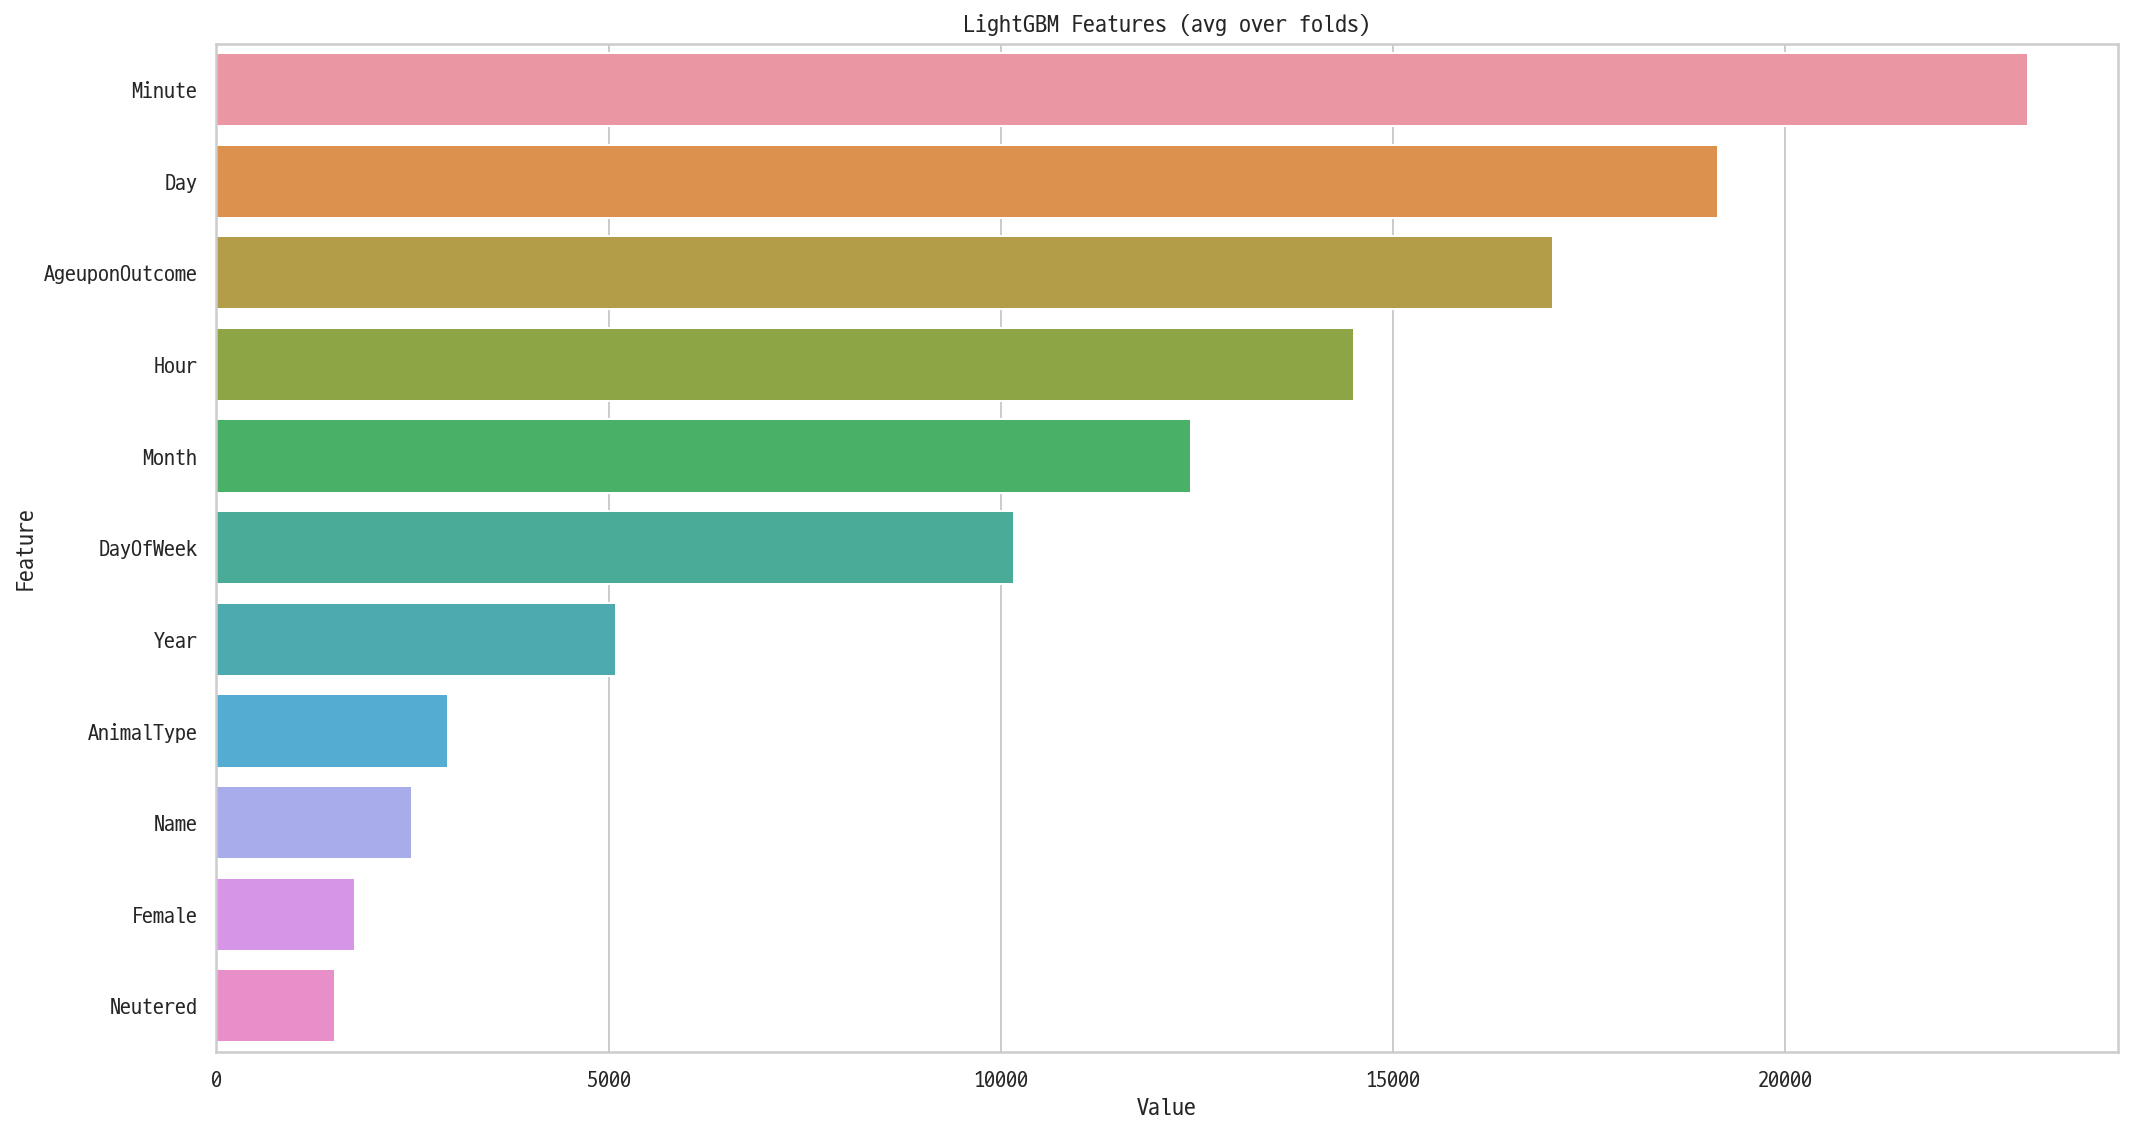

In [8]:
feature_imp = pd.DataFrame(list(zip(gbm.feature_importances_, df_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).loc[:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## 2.2 솔루션 2

- Outcome데이터 내에서 **Intake 당시에도 알수 있는 Feature만 선택**하여 진행

### 2.2.1 데이터 탐색 및 전처리
#### [ Featues ]
- **OutcomeType** : 최종 보호&관리 결과, 종속 변수
    - 'Euthanasia', 'Return_to_owner', 'Adoption', 'Transfer', 'Died'

- **AnimalID** : 유기동물의 고유ID값

- **Name** : 유기동물의 이름은 Intake 당시에도 알수 있음
    
- **AnimalType** : 유기 동물의 종(Dog/Cat)은 Intake 당시에도 알 수 있음

- **SexuponOutcome** : Outcome 당시 성별의 성별은 Intake 당시에도 알 수 있음
    - ex) 'Neutered Male' => 'Male'
    
- **Breed** : 유기 동물의 세부 종은 Intake 당시에도 알 수 있음
    - ex) 'Domestic Shorthair Mix', 'Bulldog'

- **Color** : 동물의 털 색/패턴은 Intake 당시에도 알 수 있음
    - ex) 'Blue/White', 'Cream Tabby' 등

#### [ Feature Engineering ]
- 선택된 컬럼들에 대하여 '솔루션 1'과 동일함

In [9]:
# 전처리된 데이터(Intake 당시와 동일한 Feature만 선택된) 로드
train_reduced_prep = pd.read_csv('train_reduced_prep.csv')
# 데이터 타입 int로 변환
trans_type(train_reduced_prep, train_reduced_prep.columns, 'int')
# 독립변수
df_train = train_reduced_prep.drop(['OutcomeType'], axis=1)
# 종속변수
df_target = train_reduced_prep['OutcomeType']

#### [ Train and Test Split ]
- Train 70% / Test 30%

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_train.values, df_target.values, 
                                                    test_size=0.3, random_state=0, stratify=df_target.values)

### 2.1.2 Model 구현
#### [ LightGBM ]
- 그리드 서치로 하이퍼 파라미터 설정
    - `n_estimators` : 200
    - `max_depth` : 5
    - `learning_rate` : 0.05

In [11]:
gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0, n_jobs=3)
gbm = gbm.fit(X_train, y_train)

#### [ Confusion Matrix ]

In [12]:
confusion_matrix(y_test, gbm.predict(X_test))

array([[2706,    0,    0,   81,  444],
       [  19,    0,    0,    0,   40],
       [ 225,    0,    0,   13,  228],
       [1267,    0,    0,  126,   43],
       [1346,    0,    0,   70, 1411]])

#### [ Classification Report ]
-'Died'와 'Enthanasia'에 대하여 'Precision'과 'Recall'은 0으로 확인

In [13]:
target_names = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
print(classification_report(y_test, gbm.predict(X_test), target_names=target_names))

                 precision    recall  f1-score   support

       Adoption       0.49      0.84      0.62      3231
           Died       0.00      0.00      0.00        59
     Euthanasia       0.00      0.00      0.00       466
Return_to_owner       0.43      0.09      0.15      1436
       Transfer       0.65      0.50      0.57      2827

      micro avg       0.53      0.53      0.53      8019
      macro avg       0.31      0.28      0.27      8019
   weighted avg       0.50      0.53      0.47      8019



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### [ Feature Importance ]
- Importance 순으로 상위 10개 Feature 추출
- 저조한 성능 원인
    - **Intake** 당시에도 알 수 있는 Feature는 **Outcome Feature 보다 Importance가 상대적으로 매우 낮은 것으로 확인**

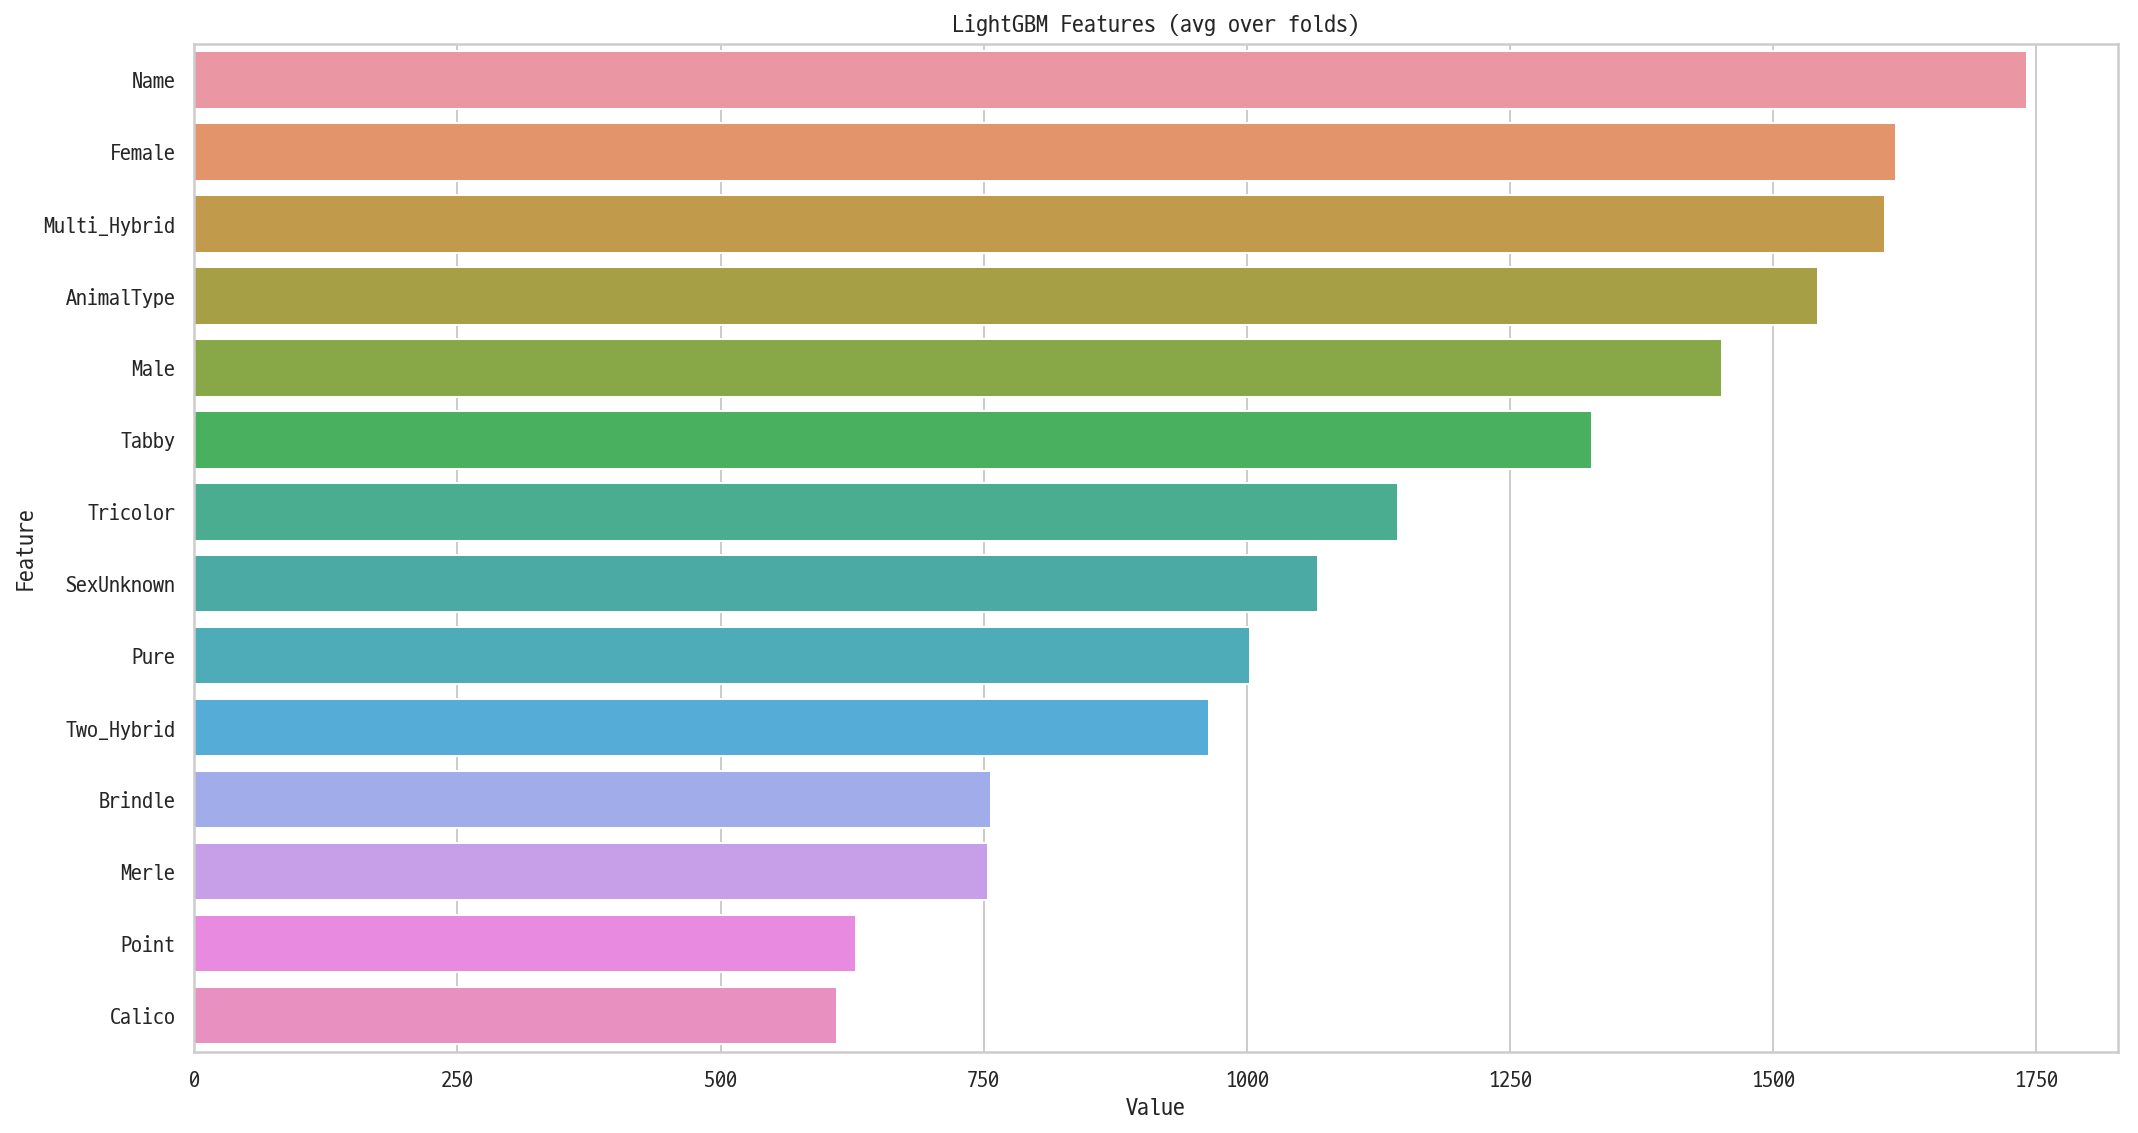

In [14]:
feature_imp = pd.DataFrame(list(zip(gbm.feature_importances_, df_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).loc[:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## 2.3 솔루션 3

- Intake 당시의 데이터([Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm)) 확보 및 기존의 Train 데이터와 Merge
- Intake 데이터
    - 2013-10-01부터 현재까지의 데이터
    - AnimalID가 여러번 중복 => 한 동물이 센터에 여러번 맡겨지는 경우 발생
- 기존 Train 데이터 내 'Outcome Date'를 기준으로 가장 최근의 'Intake Date'가 포함된 데이터를 선택하여 중복문제를 해결
- Merge된 데이터는 기존 Train 데이터 대비 663개 감소
- Test 데이터는 고유한 AnimalID가 존재하지 않기 때문에 Merge할 경우 데이터의 신뢰성을 보장할 수 없으므로 활용하지 않는 것으로 결정

### 2.3.1 데이터로드

In [15]:
## 기존 Train 데이터
train = pd.read_csv('train.csv')

## Intake 데이터 
intake = pd.read_csv('Austin_Animal_Center_Intakes.csv')

In [16]:
intake.tail()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
93830,A786815,NaN,01/02/2019 01:39:00 PM,01/02/2019 01:39:00 PM,Dessau Road And East Applegate Drive in Austin...,Stray,Normal,Dog,Intact Male,3 years,German Shepherd Mix,Tricolor/Brown
93831,A786598,Ranger,12/28/2018 12:43:00 PM,12/28/2018 12:43:00 PM,7337 Dungarees Way in Del Valle (TX),Stray,Normal,Dog,Intact Male,1 month,German Shepherd Mix,Black/Brown
93832,A786631,Coco,12/28/2018 05:30:00 PM,12/28/2018 05:30:00 PM,1604 Wheless Lane in Austin (TX),Stray,Normal,Dog,Intact Female,2 years,Chihuahua Shorthair Mix,Red
93833,A786845,Poochie,01/02/2019 06:43:00 PM,01/02/2019 06:43:00 PM,East William Cannon And Bluff Springs Road in ...,Stray,Normal,Dog,Neutered Male,5 years,Bluetick Hound,Tricolor/White
93834,A786577,NaN,12/27/2018 06:08:00 PM,12/27/2018 06:08:00 PM,Moore Road And Fm 973 in Austin (TX),Stray,Normal,Dog,Neutered Male,8 years,Rat Terrier Mix,Tricolor/White


In [17]:
# 머지할 train셋의 칼럼명들과 동일한 형식으로 바꿔줌
intake = intake.rename(columns={'Animal ID':'AnimalID','Found Location':'FoundLocation','Intake Type':'IntakeType', 'Intake Condition':'IntakeCondition',
                                'Sex upon Intake': 'SexUponIntake','Age upon Intake':'AgeUponIntake', 'DateTime': 'Intake_Datetime', 
                                'Animal Type': 'AnimalType'})

In [18]:
# DatetTime과 똑같은 칼럼인 MonthYear 삭제
intake = intake.drop(columns='MonthYear')

In [19]:
# intake과 train 셋의 DateTime칼럼을 datetime으로 형변환
intake.Intake_Datetime = pd.to_datetime(intake.Intake_Datetime)
train.DateTime = pd.to_datetime(train.DateTime)

### 2.3.2 'AnimalID'를 key로 Train데이터와 Intake 데이터 Merge

In [20]:
train_merged = pd.merge(train, intake, on='AnimalID', how='left')

In [21]:
train_merged.tail()

,AnimalID,Name_x,DateTime,OutcomeType,OutcomeSubtype,AnimalType_x,SexuponOutcome,AgeuponOutcome,Breed_x,Color_x,Name_y,Intake_Datetime,FoundLocation,IntakeType,IntakeCondition,AnimalType_y,SexUponIntake,AgeUponIntake,Breed_y,Color_y
30249,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,NaN,2015-05-13 18:53:00,1613 E M Franklin Ave in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
30250,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,NaN,2016-01-09 14:34:00,Night Star And Warrior Ln in Del Valle (TX),Stray,Normal,Cat,Intact Female,3 months,Domestic Shorthair Mix,Brown Tabby
30251,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,Zeus,2015-03-06 11:17:00,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
30252,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,NaN,2014-04-25 14:40:00,1203 Cometa St in Austin (TX),Owner Surrender,Sick,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
30253,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,NaN,2015-07-01 11:00:00,1012 Neans Dr in Austin (TX),Stray,Normal,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [22]:
# 둘 데이터셋에 중복으로 있던 네 개의 칼럼은 train의 칼럼으로 남기고 intake의 칼럼은 삭제
train_merged = train_merged.drop(columns=['Name_y','Breed_y','Color_y','AnimalType_y'])

# 칼럼명 정리
train_merged = train_merged.rename(columns={'Name_x':'Name','Breed_x':'Breed','Color_x':'Color','AnimalType_x':'AnimalType', 
                                            'DateTime': 'Outcome_Datetime'})

In [23]:
# 머지된 데이터셋에서 intake datetime이 outcome datetime보다 늦은 데이터들만 남기기
train_merged = train_merged[train_merged.Outcome_Datetime >= train_merged.Intake_Datetime]

In [24]:
len(train), len(train_merged)

(26729, 28240)

In [25]:
# AnimalID 한 개당 여러 개의 데이터가 있을 경우 intake datetime이 가장 최근인 데이터 하나만 남기고 나머지는 드랍
train_merged = train_merged.sort_values(by='Intake_Datetime', ascending=False).drop_duplicates('AnimalID').reset_index(drop=True)

In [26]:
len(train_merged)

26066

In [27]:
train_merged.tail()

,AnimalID,Name,Outcome_Datetime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intake_Datetime,FoundLocation,IntakeType,IntakeCondition,SexUponIntake,AgeUponIntake
26061,A664266,NaN,2013-10-05 15:06:00,Transfer,Partner,Dog,Intact Female,1 year,Chihuahua Shorthair Mix,Buff,2013-10-01 11:09:00,Payton And 183 in Austin (TX),Stray,Normal,Intact Female,1 year
26062,A664257,Pippin,2013-10-24 13:31:00,Adoption,Foster,Dog,Spayed Female,4 years,Podengo Pequeno Mix,Black,2013-10-01 11:01:00,Burleson in Travis (TX),Stray,Normal,Intact Female,4 years
26063,A664238,NaN,2013-10-01 16:47:00,Euthanasia,Medical,Cat,Unknown,4 months,American Shorthair Mix,Black/White,2013-10-01 09:33:00,Outside Jurisdiction,Stray,Normal,Unknown,4 months
26064,A664235,NaN,2013-10-01 10:39:00,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Unknown,1 week
26065,A664237,NaN,2013-10-01 10:44:00,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Unknown,1 week


### 2.3.3 Merge가 완료된 데이터를 CSV 파일형식으로 변환

In [28]:
train_merged.to_csv('train_merged.csv', index=False)

## 2.4 솔루션 4
- **Merge된 Train 데이터**를 사용하여 진행
- Multi Classification을 **Binary Classification**으로 변환
    - 'Return_to_owner', 'Adoption', 'Transfer' => **Safe**
    - 'Euthanasia', 'Died' => **Danger**
- Merge된 **Train 데이터 내에서 Test 데이터를 별도로 분리**
- 성능 매트릭스
    - **Recall Unweighted Mean**
    - Recall은 높고  Danger에 속하는 동물을 최대한 선별가능
    - Fall-Out이 낮을수록 실제로는 Safe에 속하는 동물들을 Danger라고 오판단 하는 실수를 다소 방지할 수 있음

### 2.4.1 데이터 로드

In [29]:
train_merged = pd.read_csv('train_merged.csv', parse_dates=['Intake_Datetime', 'Outcome_Datetime'])
print(train_merged.shape)
train_merged.tail()

(26066, 16)


,AnimalID,Name,Outcome_Datetime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intake_Datetime,FoundLocation,IntakeType,IntakeCondition,SexUponIntake,AgeUponIntake
26061,A664266,NaN,2013-10-05 15:06:00,Transfer,Partner,Dog,Intact Female,1 year,Chihuahua Shorthair Mix,Buff,2013-10-01 11:09:00,Payton And 183 in Austin (TX),Stray,Normal,Intact Female,1 year
26062,A664257,Pippin,2013-10-24 13:31:00,Adoption,Foster,Dog,Spayed Female,4 years,Podengo Pequeno Mix,Black,2013-10-01 11:01:00,Burleson in Travis (TX),Stray,Normal,Intact Female,4 years
26063,A664238,NaN,2013-10-01 16:47:00,Euthanasia,Medical,Cat,Unknown,4 months,American Shorthair Mix,Black/White,2013-10-01 09:33:00,Outside Jurisdiction,Stray,Normal,Unknown,4 months
26064,A664235,NaN,2013-10-01 10:39:00,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Unknown,1 week
26065,A664237,NaN,2013-10-01 10:44:00,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,2013-10-01 08:33:00,Abia in Austin (TX),Stray,Normal,Unknown,1 week


In [30]:
# Merge 된 Train 데이터 중 종속변수(OutcomeType)와 Intake 당시 Feature만 남기고 드랍
train_intake = train_merged.drop(
    ['Outcome_Datetime', 'SexuponOutcome', 'AgeuponOutcome', 'OutcomeSubtype', 'FoundLocation'],
    axis=1)
print(train_intake.shape)
train_intake.tail()

(26066, 11)


,AnimalID,Name,OutcomeType,AnimalType,Breed,Color,Intake_Datetime,IntakeType,IntakeCondition,SexUponIntake,AgeUponIntake
26061,A664266,NaN,Transfer,Dog,Chihuahua Shorthair Mix,Buff,2013-10-01 11:09:00,Stray,Normal,Intact Female,1 year
26062,A664257,Pippin,Adoption,Dog,Podengo Pequeno Mix,Black,2013-10-01 11:01:00,Stray,Normal,Intact Female,4 years
26063,A664238,NaN,Euthanasia,Cat,American Shorthair Mix,Black/White,2013-10-01 09:33:00,Stray,Normal,Unknown,4 months
26064,A664235,NaN,Transfer,Cat,Domestic Shorthair Mix,Orange/White,2013-10-01 08:33:00,Stray,Normal,Unknown,1 week
26065,A664237,NaN,Transfer,Cat,Domestic Shorthair Mix,Orange/White,2013-10-01 08:33:00,Stray,Normal,Unknown,1 week


### 2.4.2 결측값

#### 1) 결측값 검사

In [31]:
train_intake.isna().sum()

AnimalID              0
Name               7584
OutcomeType           0
AnimalType            0
Breed                 0
Color                 0
Intake_Datetime       0
IntakeType            0
IntakeCondition       0
SexUponIntake         1
AgeUponIntake         0
dtype: int64

#### 2) 결측값 처리

##### SexUponIntake

In [32]:
# 결측값 'Unknown'으로 대체
train_intake["SexUponIntake"].fillna("Unknown", inplace=True)

##### Name
이후 전처리 과정에서 이름 없음(0)으로 처리

### 2.4.3 Binary Classification으로 변환
- Imbalance가 심한 데이터로 모든 OutcomeType을 정확하게 맞추는 것에 한계가 있음
- Animal Center에서 실질적으로 필요한 것은 좀 더 신경을 써야하는 동물을 선별해야 한다고 판단됨
- 종속변수의 범주를 'Danger'와 'safe' 로 변환
    - 'Return_to_owner', 'Adoption', 'Transfer' => **Safe**
    - 'Euthanasia', 'Died' => **Danger**

In [33]:
train_intake['OutcomeType'].value_counts()

Adoption           10382
Transfer            9216
Return_to_owner     4750
Euthanasia          1529
Died                 189
Name: OutcomeType, dtype: int64

In [34]:
# Target Value => Danger/Safe로 변환
train_intake['OutcomeType'] = \
train_intake['OutcomeType'].apply(lambda x: "Danger" if x in ["Died", "Euthanasia"] else "Safe")

In [35]:
train_intake['OutcomeType'].value_counts()

Safe      24348
Danger     1718
Name: OutcomeType, dtype: int64

### 2.4.4 EDA

In [36]:
## 데이터 시각화를 위한 데이터 가공

train_merged = pd.read_csv('train_merged.csv', parse_dates=['Intake_Datetime', 'Outcome_Datetime'])
intake = train_merged.copy()

intake['Name'] = intake['Name'].fillna(0) # 없으면 0을 우선 대입 한개존재
intake['YesName'] = intake['Name'].apply(lambda x :0 if type(x) == int else 1)
intake['AgeUponIntake'] = intake['AgeUponIntake'].fillna(0)
numeric_test = intake['AgeUponIntake'].str.split(" ", n=1, expand = True)
numeric_test[1] = numeric_test[1].apply(lambda x: 365 if x == 'year' else (365 if x == 'years'\
            else(30 if x=='month' else(30 if x=='months' else\
            7 if x=='week' else(7 if x=='weeks' else(1 if x=='days'\
            else(1 if x=='day' else(0))))))))
numeric_test = numeric_test.fillna(0)
numeric_test[2] = numeric_test[0].astype(int)*numeric_test[1].astype(int)
intake['ConvertToDate'] = numeric_test[2]

intake["SexUponIntake"].fillna("Neutered Male", inplace=True)
train_sex = intake["SexUponIntake"].str.split(expand=True).fillna("Unknown")
train_sex[0] = train_sex[0].apply(lambda x: "Neutered"\
                              if (x.find("Neutered") != -1) or (x.find("Spayed") != -1) else x)

lb_tact = LabelBinarizer()
df_tact = pd.DataFrame(lb_tact.fit_transform(train_sex[0]),\
                   columns=["Intact", "IntactUnknown", "Neutered"])
intake = pd.concat([intake,df_tact],axis=1)

lb_sex = LabelBinarizer()
df_sex = pd.DataFrame(lb_sex.fit_transform(train_sex[1]),\
                  columns=["Female", "Male", "SexUnknown"])
intake = pd.concat([intake,df_sex],axis=1)


intake['BreedType'] = intake["Breed"].apply(lambda x: "Multi_Hybrid" if x.find("Mix") != -1\
                                   else "Two_Hybrid" if x.find("/") != -1 else "Pure")

intake['MixOrNot'] = intake['Breed'].apply(lambda x: 1 if x.find('Mix') == -1 else 0)
intake['OutcomeType'] = intake['OutcomeType'].apply(lambda x: 'Danger' if x=='Died' else('Danger' if x=='Euthanasia' else 'safe'))

intake['year'] = intake['Intake_Datetime'].dt.year
intake['month'] = intake['Intake_Datetime'].dt.month
intake['day'] = intake['Intake_Datetime'].dt.day
intake['hour'] = intake['Intake_Datetime'].dt.hour
intake['min'] = intake['Intake_Datetime'].dt.minute
intake['dayofweek'] = intake['Intake_Datetime'].dt.dayofweek

name = intake.groupby(["YesName", "OutcomeType"]).size().reset_index(name="Counts")

ratio_list = []

for idx in range(len(name)):
    if name.iloc[idx][0] == 0:
        ratio_list.append(name.loc[idx][2] / list(intake['YesName'].value_counts())[1])

    if name.iloc[idx][0] == 1:
        ratio_list.append(name.loc[idx][2] / list(intake['YesName'].value_counts())[0])
        
ratio = pd.DataFrame({"ratio" : ratio_list})
name = pd.concat([name, ratio], axis=1)

In [37]:
## 플롯팅을 위한 함수정의

def drawing_plot(column_name, df, showing_temp_dataframe, method):
    temp_dataframe = df.groupby([column_name, "OutcomeType"]).size().reset_index(name="counts")

    ratio_list = []
    temp_dic = {}
    temp_list = []

    for idx in range(len(temp_dataframe)):
        if temp_dataframe.ix[idx][0] not in temp_list :
            temp_list.append(temp_dataframe.ix[idx][0])

    for data in temp_list:
        counts = 0
        for idx in range(len(temp_dataframe)):
            if temp_dataframe.ix[idx][0] == data:
                counts += temp_dataframe.ix[idx][2]
        temp_dic[data] = counts
    
    for data in temp_list:
        for idx in range(len(temp_dataframe)):
            if temp_dataframe.ix[idx][0] == data:
                ratio_list.append(temp_dataframe.ix[idx][2] / temp_dic[data])

    ratio = pd.DataFrame({"ratio" : ratio_list})
    temp_dataframe = pd.concat([temp_dataframe, ratio], axis=1)
    
    if showing_temp_dataframe:
        print(temp_dataframe)
        
    if method == 'counts':
        plt.figure(figsize=(10, 5))
        sns.barplot(x='OutcomeType',y='counts',hue=column_name ,data=temp_dataframe)
        plt.show()
    
    if method == 'ratio':
        plt.figure(figsize=(10, 5))
        sns.barplot(x='OutcomeType',y='ratio',hue=column_name ,data=temp_dataframe)
        plt.show()
        
    return None

### Name(이름)에 따른 분포차이
- 이름이 없으면 위험군에 분류될 가능성이 더 높다.

   YesName OutcomeType  counts     ratio
0        0      Danger     923  0.121704
1        0        safe    6661  0.878296
2        1      Danger     795  0.043015
3        1        safe   17687  0.956985


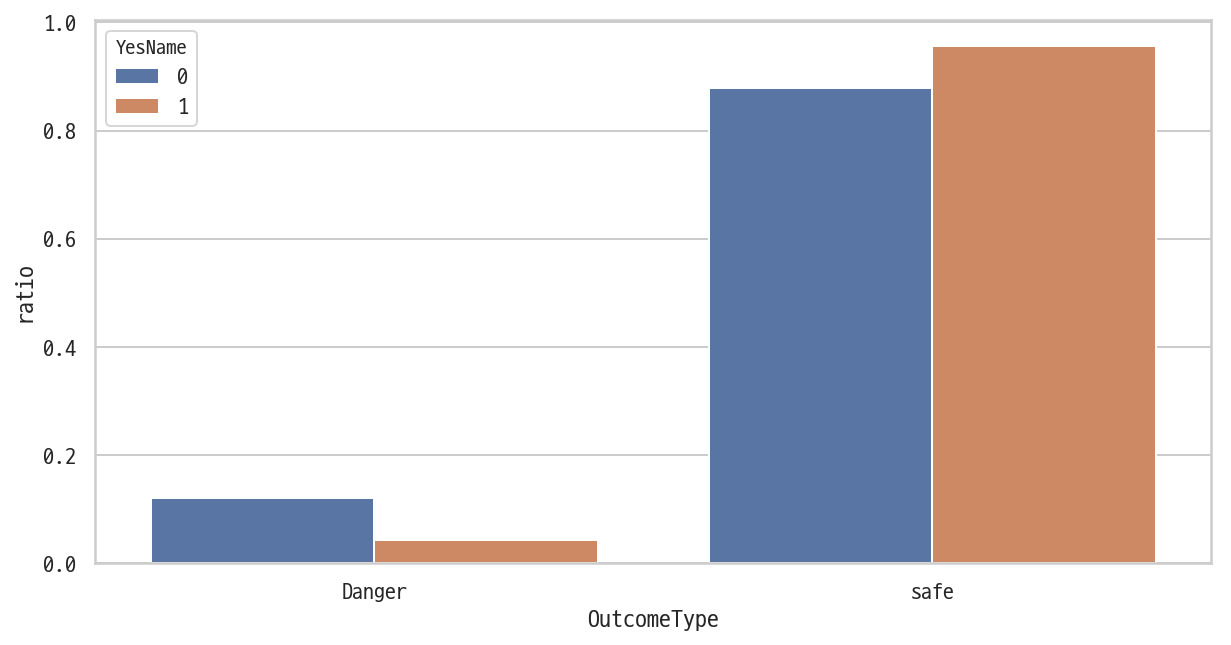

In [38]:
drawing_plot('YesName',intake, True, 'ratio')

### 중성화 여부에 따른 분포 차이

   Neutered OutcomeType  counts     ratio
0         0      Danger    1593  0.063730
1         0        safe   23403  0.936270
2         1      Danger     125  0.116822
3         1        safe     945  0.883178


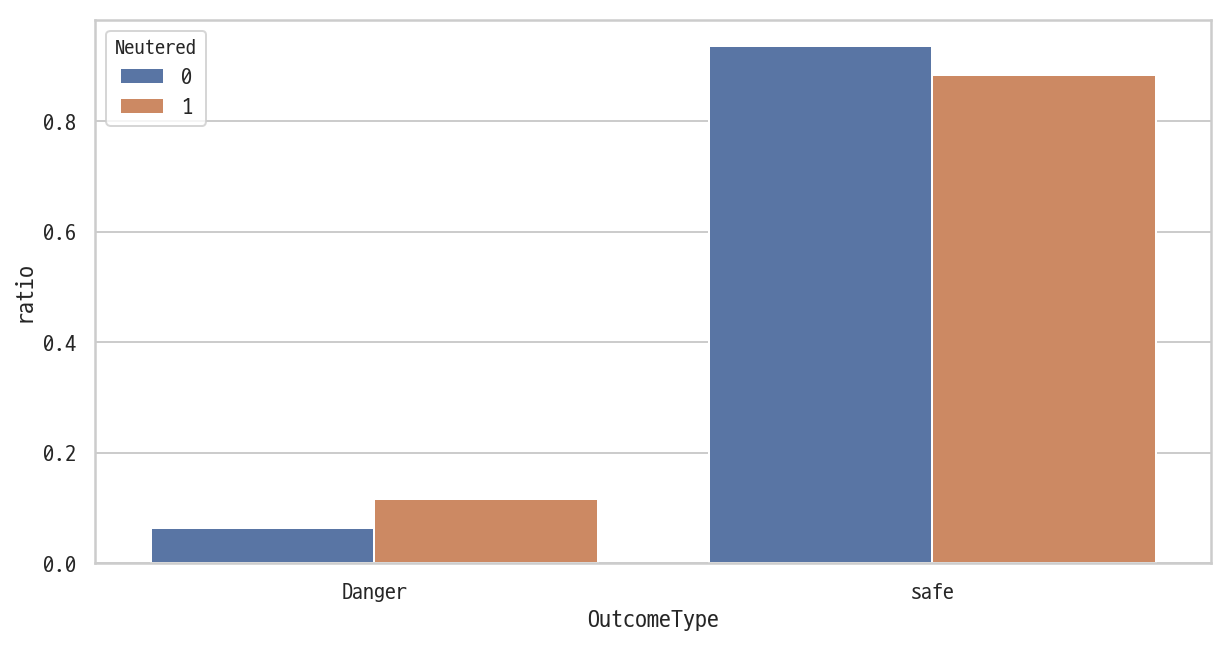

In [39]:
drawing_plot('Neutered',intake, True, 'ratio')

### 동물의 종류에 따른 분포 차이
- Danger만 따로 떼서 보면 고양이가 위험군일 가능성이 더 높다.

  AnimalType OutcomeType  counts     ratio
0        Cat      Danger     842  0.078100
1        Cat        safe    9939  0.921900
2        Dog      Danger     876  0.057311
3        Dog        safe   14409  0.942689


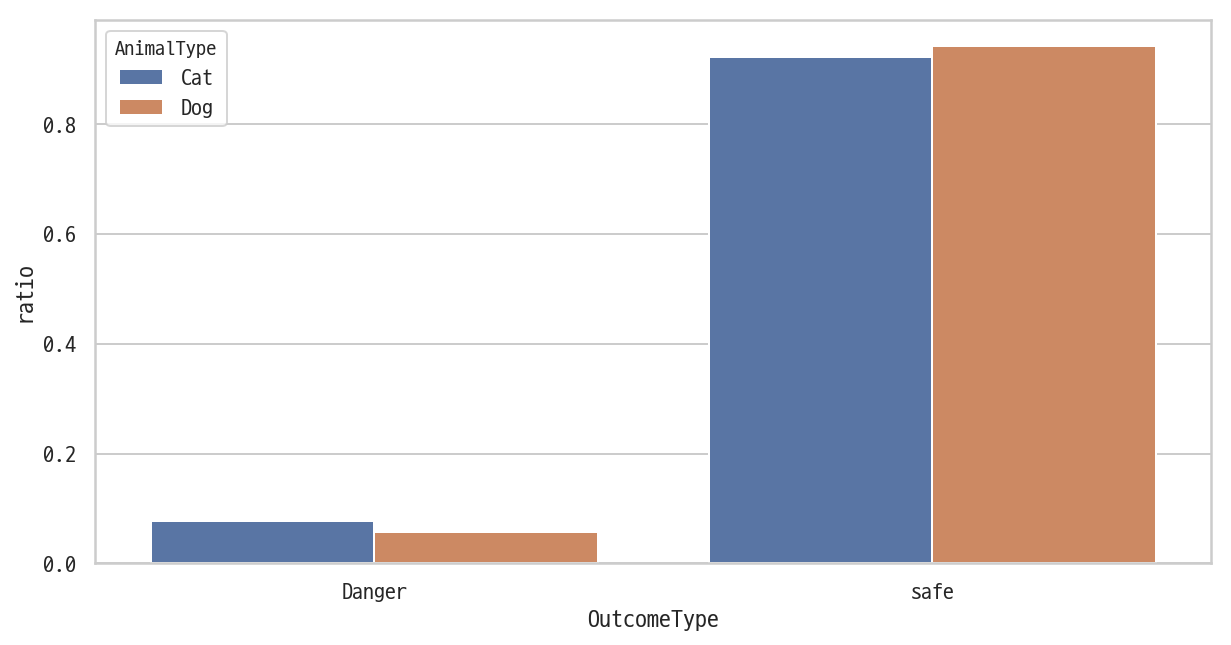

In [40]:
drawing_plot('AnimalType',intake, True, 'ratio')

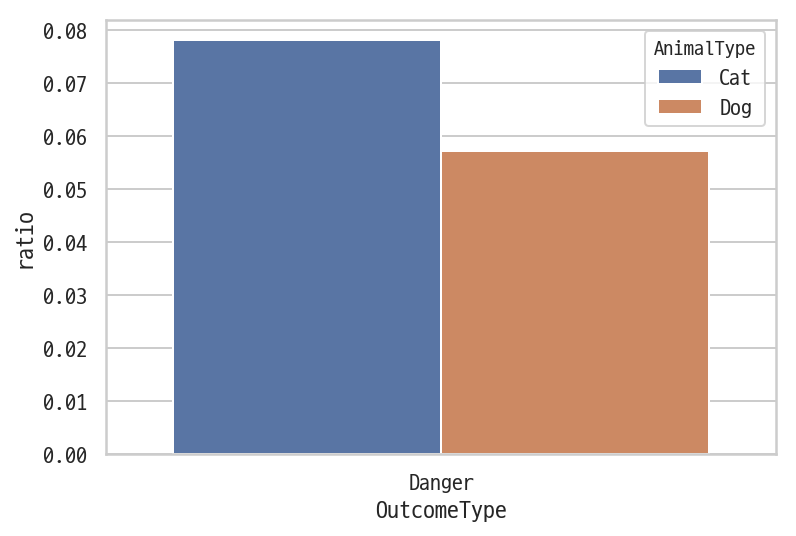

In [41]:
intact = intake.groupby(["Neutered", "OutcomeType"]).size().reset_index(name="Counts")

ratio_list = []

for idx in range(len(intact)):
    if intact.iloc[idx][0] == 0:
        ratio_list.append(intact.loc[idx][2] / list(intake['Neutered'].value_counts())[0])

    if intact.iloc[idx][0] == 1:
        ratio_list.append(intact.loc[idx][2] / list(intake['Neutered'].value_counts())[1])
        
ratio = pd.DataFrame({"ratio" : ratio_list})
intact = pd.concat([intact, ratio], axis=1)

aniType = intake.groupby(["AnimalType", "OutcomeType"]).size().reset_index(name="Counts")

ratio_list = []

for idx in range(len(intact)):
    if aniType.iloc[idx][0] == 'Dog':
        ratio_list.append(aniType.loc[idx][2] / list(intake['AnimalType'].value_counts())[0])

    if aniType.iloc[idx][0] == 'Cat':
        ratio_list.append(aniType.loc[idx][2] / list(intake['AnimalType'].value_counts())[1])
        
ratio = pd.DataFrame({"ratio" : ratio_list})
aniType = pd.concat([aniType, ratio], axis=1)

sns.barplot(x="OutcomeType", y="ratio", hue="AnimalType", data=aniType[aniType['OutcomeType']=='Danger'])
plt.show()

### 성별에 따른 분포차이
- 유의 하지 않은 것으로 나타났다

   Male OutcomeType  counts     ratio
0     0      Danger     820  0.062725
1     0        safe   12253  0.937275
2     1      Danger     898  0.069114
3     1        safe   12095  0.930886


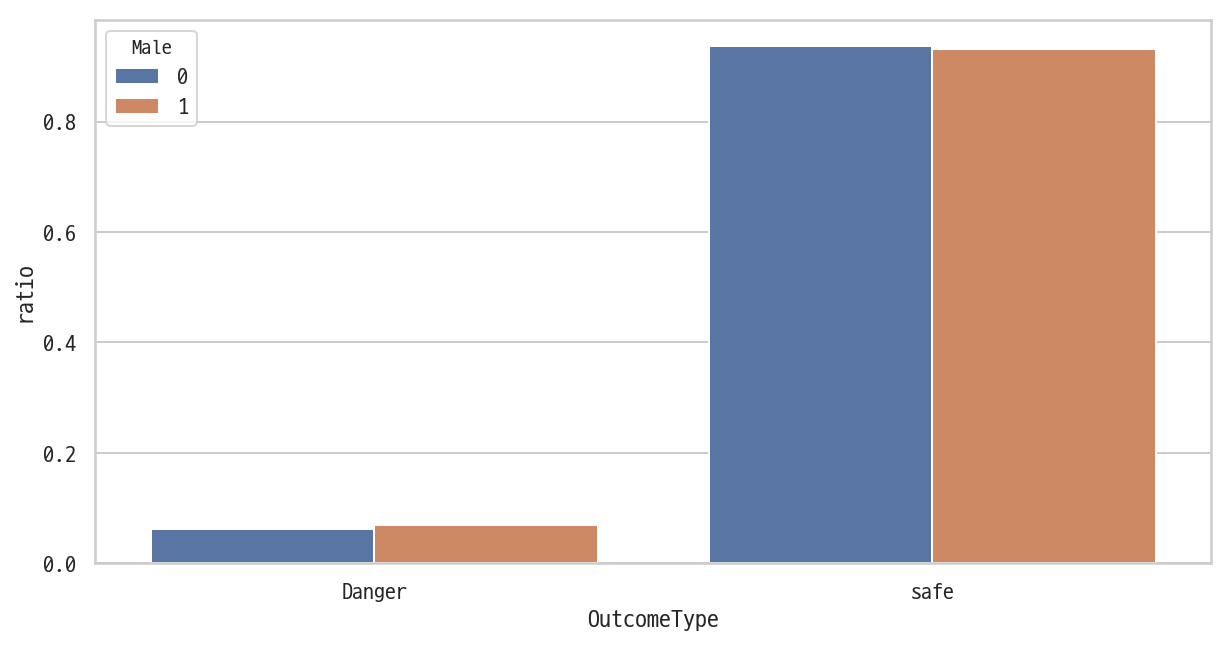

In [42]:
drawing_plot('Male',intake, True, 'ratio')

### IntakeAge에 따른 분포

    ConvertToDate OutcomeType  counts     ratio
0               0      Danger      11  0.095652
1               0        safe     104  0.904348
2               1      Danger      13  0.101562
3               1        safe     115  0.898438
4               2      Danger       7  0.050360
5               2        safe     132  0.949640
6               3      Danger       6  0.046512
7               3        safe     123  0.953488
8               4      Danger       4  0.053333
9               4        safe      71  0.946667
10              5      Danger       1  0.022222
11              5        safe      44  0.977778
12              6      Danger       2  0.029851
13              6        safe      65  0.970149
14              7      Danger      26  0.062954
15              7        safe     387  0.937046
16             14      Danger      20  0.035088
17             14        safe     550  0.964912
18             21      Danger      32  0.035874
19             21        safe     860  0

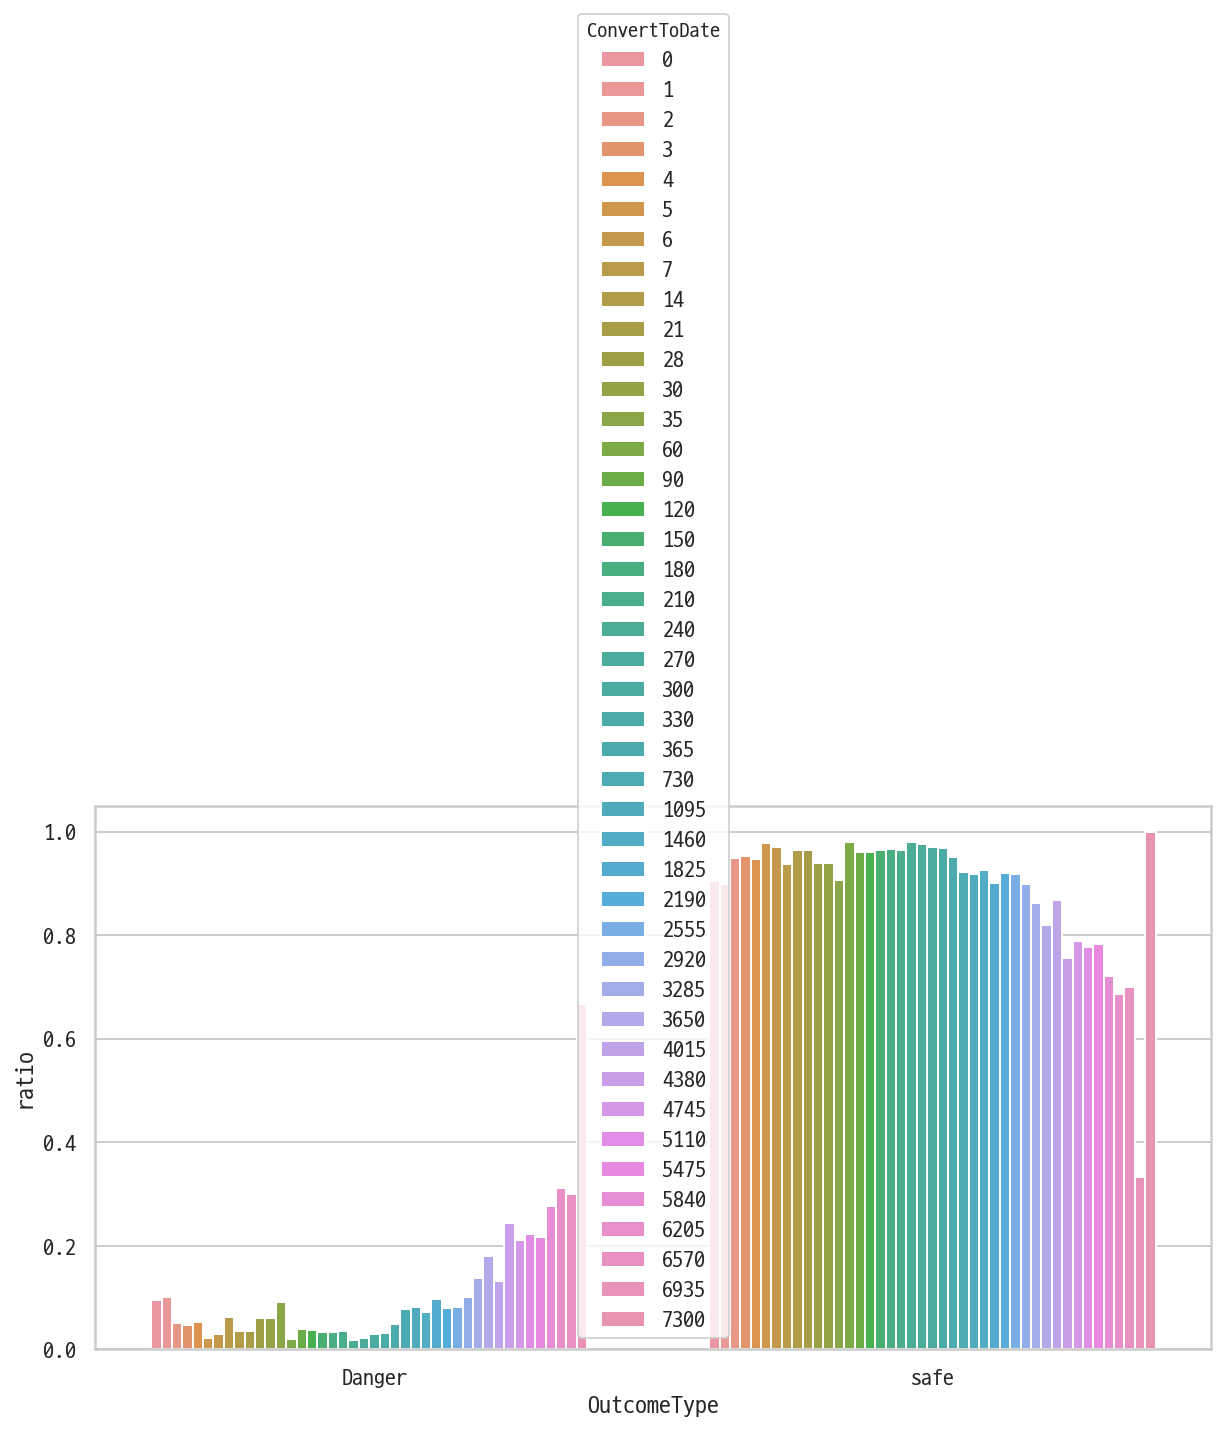

In [43]:
drawing_plot('ConvertToDate',intake, True, 'ratio')

### intake당시의 Type에 대한 분포 차이
- 주인이 안락사를 요구하면 당연히 위험군에 속할 가능성이 높아진다

           IntakeType OutcomeType  counts     ratio
0  Euthanasia Request      Danger     111  0.816176
1  Euthanasia Request        safe      25  0.183824
2     Owner Surrender      Danger     342  0.070690
3     Owner Surrender        safe    4496  0.929310
4       Public Assist      Danger      81  0.052090
5       Public Assist        safe    1474  0.947910
6               Stray      Danger    1184  0.060603
7               Stray        safe   18353  0.939397


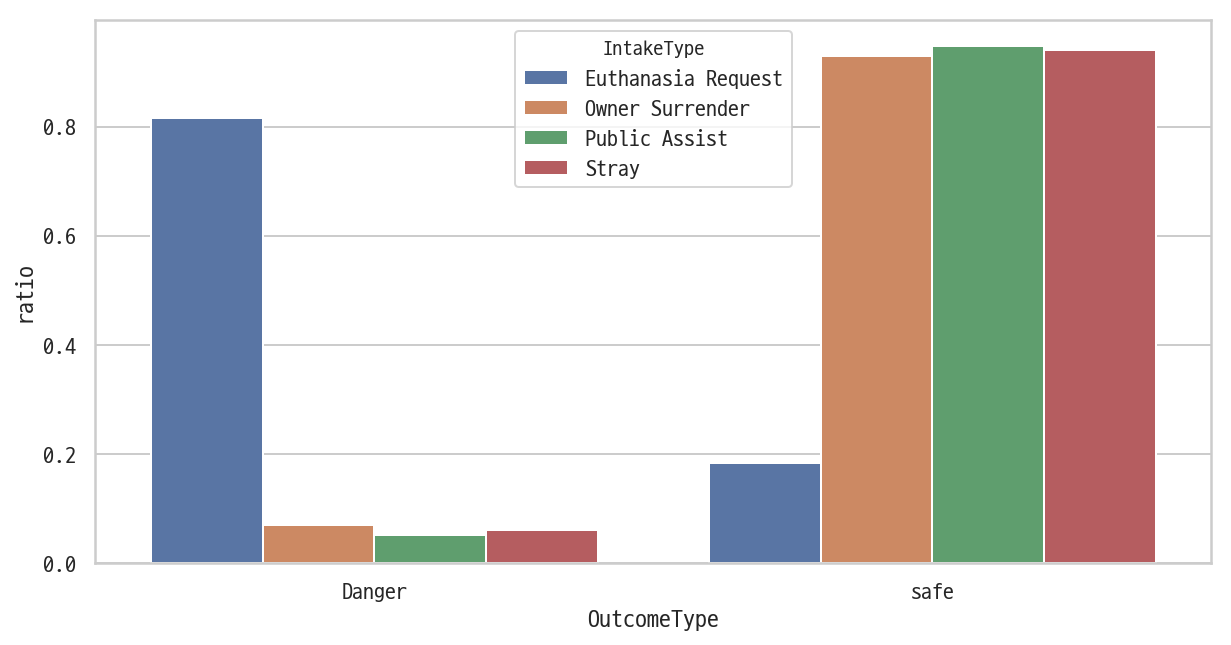

In [44]:
drawing_plot('IntakeType',intake, True, 'ratio')

### 순종과 혼종(MIx)에 따른 분포차이
- Mix견일 수록 위험군에 속할 가능성이 높다

   MixOrNot OutcomeType  counts     ratio
0         0      Danger    1515  0.069806
1         0        safe   20188  0.930194
2         1      Danger     203  0.046528
3         1        safe    4160  0.953472


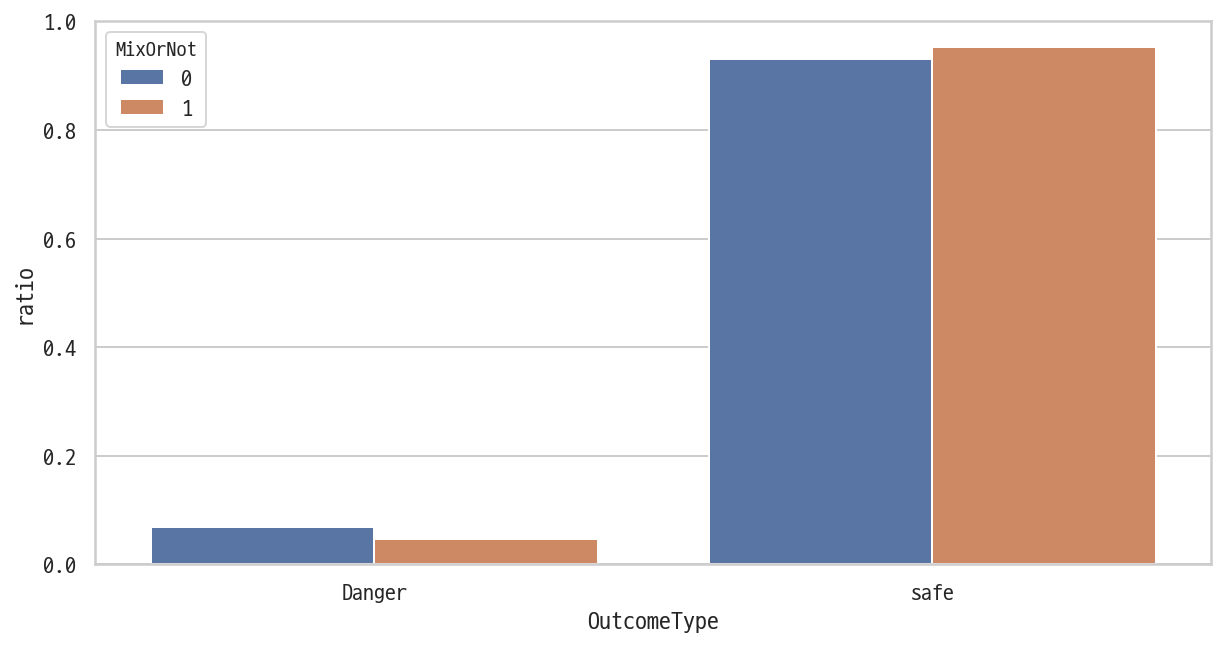

In [45]:
drawing_plot('MixOrNot',intake, True, 'ratio')

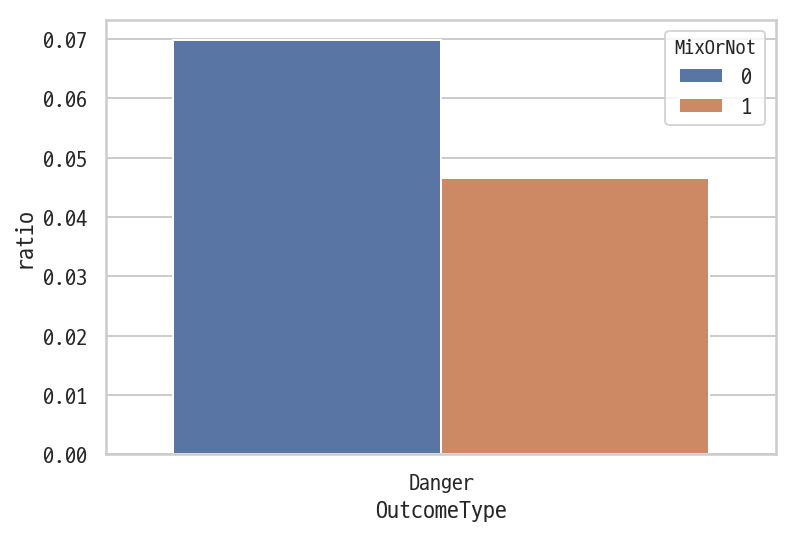

In [46]:
MixType = intake.groupby(["MixOrNot", "OutcomeType"]).size().reset_index(name="Counts")

ratio_list = []

for idx in range(len(MixType)):
    if MixType.iloc[idx][0] == 0:
        ratio_list.append(MixType.loc[idx][2] / list(intake['MixOrNot'].value_counts())[0])

    if MixType.iloc[idx][0] == 1:
        ratio_list.append(MixType.loc[idx][2] / list(intake['MixOrNot'].value_counts())[1])
        
ratio = pd.DataFrame({"ratio" : ratio_list})
MixType = pd.concat([MixType, ratio], axis=1)

sns.barplot(x="OutcomeType", y="ratio", hue="MixOrNot", data=MixType[MixType['OutcomeType']=='Danger'])
plt.show()

### Intake당시 Condtion에 따른 분포 차이
- 나이가 들었을 수록(Aged), 다쳤을 수록(Injured), 아플수록 위험성이 높았고(sick),
- 야생일수록(Feral), 보호를 받을수록(Nursing), 임신을 했을수록(Pregnant) 더 안전한 것으로 나타났다.

   IntakeCondition OutcomeType  counts     ratio
0             Aged      Danger      43  0.355372
1             Aged        safe      78  0.644628
2            Feral      Danger       2  0.048780
3            Feral        safe      39  0.951220
4          Injured      Danger     456  0.372854
5          Injured        safe     767  0.627146
6           Normal      Danger     877  0.038172
7           Normal        safe   22098  0.961828
8          Nursing      Danger      38  0.049934
9          Nursing        safe     723  0.950066
10           Other      Danger       8  0.126984
11           Other        safe      55  0.873016
12        Pregnant      Danger       1  0.090909
13        Pregnant        safe      10  0.909091
14            Sick      Danger     293  0.336395
15            Sick        safe     578  0.663605


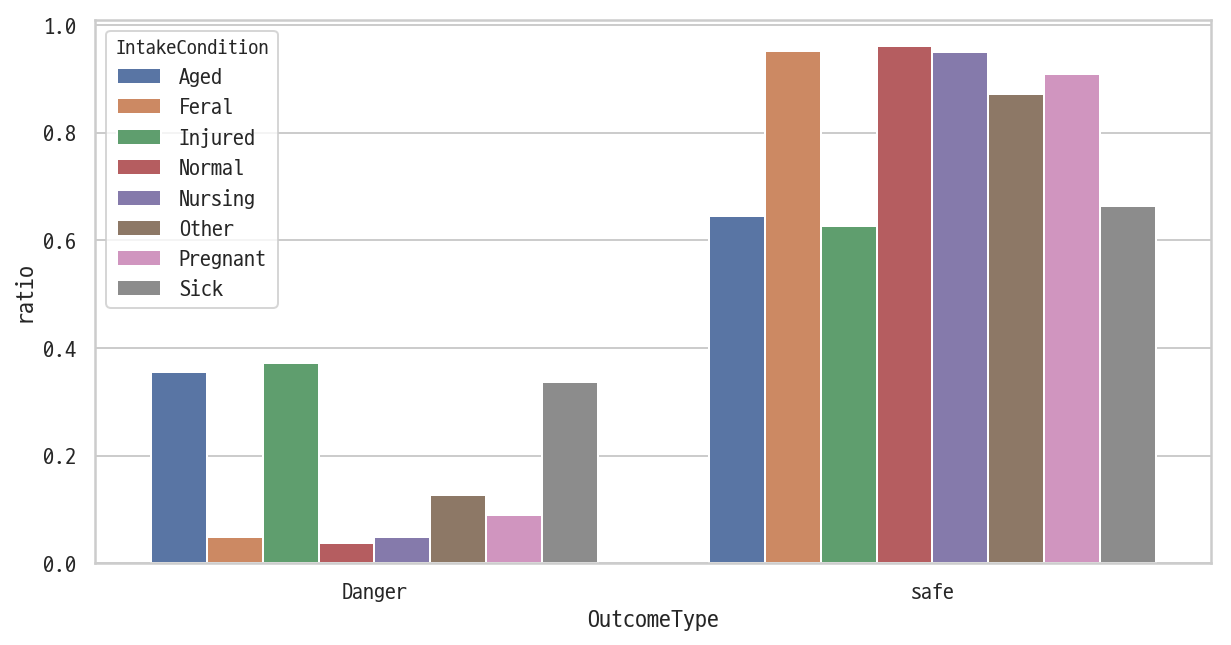

In [47]:
drawing_plot('IntakeCondition',intake, True, 'ratio')

### Mix견 세분화
- 순종과 2가지 혼종은 유의한 차이가 보이지 않았지만, 잡종은 위험도가 유의하게 높은 것으로 나타났다.

      BreedType OutcomeType  counts     ratio
0  Multi_Hybrid      Danger    1515  0.069806
1  Multi_Hybrid        safe   20188  0.930194
2          Pure      Danger      71  0.051787
3          Pure        safe    1300  0.948213
4    Two_Hybrid      Danger     132  0.044118
5    Two_Hybrid        safe    2860  0.955882


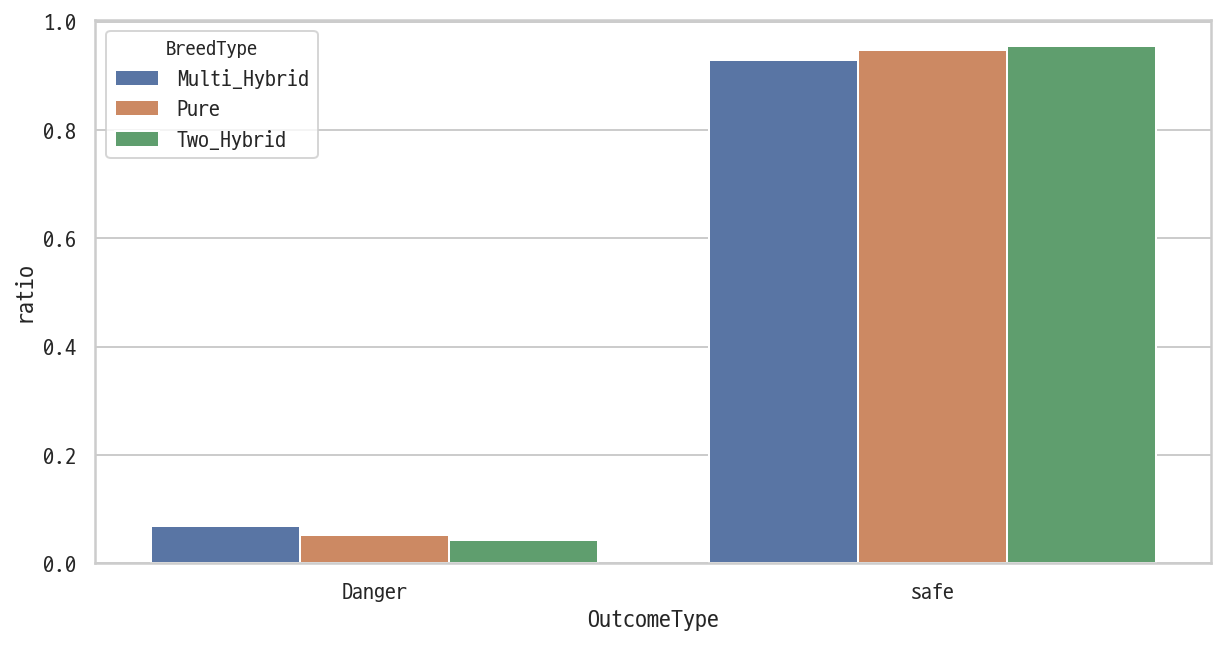

In [48]:
drawing_plot('BreedType',intake, True, 'ratio')

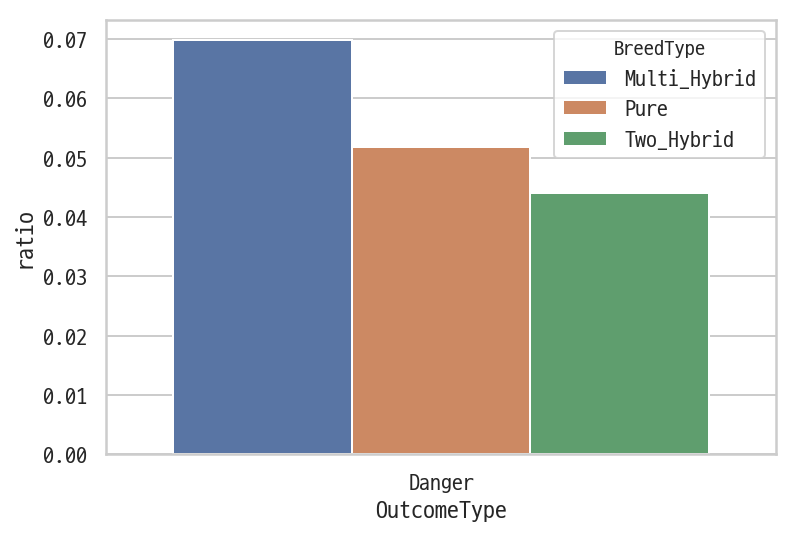

In [49]:
BreedType = intake.groupby(["BreedType", "OutcomeType"]).size().reset_index(name="Counts")

ratio_list = []

for idx in range(len(BreedType)):
    if BreedType.iloc[idx][0] == 'Multi_Hybrid':
        ratio_list.append(BreedType.loc[idx][2] / list(intake['BreedType'].value_counts())[0])

    if BreedType.iloc[idx][0] == 'Two_Hybrid':
        ratio_list.append(BreedType.loc[idx][2] / list(intake['BreedType'].value_counts())[1])
    
    if BreedType.iloc[idx][0] == 'Pure':
        ratio_list.append(BreedType.loc[idx][2] / list(intake['BreedType'].value_counts())[2])
        
        
ratio = pd.DataFrame({"ratio" : ratio_list})
BreedType = pd.concat([BreedType, ratio], axis=1)

sns.barplot(x="OutcomeType", y="ratio", hue="BreedType", data=BreedType[BreedType['OutcomeType']=='Danger'])
plt.show()

### 정리
- 위험군이라고 판단되는 Aged, injured, sick 이외에도, 이름의 유무, 순종인지 혼종인지 등이 유의미한 것으로 확인 
- 강아지인지 고양이인지에 따라서도 위험군의 차이가 유의하게 나타나므로, 이름이 없고, 고양이고, 잡종인 동물에 대해서 조금 더 섬세한 보호,관리가 필요하다고 판단

### 2.4.5 Test 데이터 분리
- 전체 데이터 중 30%를 OutcomeType의 비율을 유지하여 Test 데이터로 분리

In [50]:
train, test = train_test_split(train_intake, test_size=0.3, random_state=0,
                               stratify=train_intake['OutcomeType'].values)

In [51]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [52]:
train.tail()

,AnimalID,Name,OutcomeType,AnimalType,Breed,Color,Intake_Datetime,IntakeType,IntakeCondition,SexUponIntake,AgeUponIntake
18241,A706603,Maggie,Safe,Dog,Australian Shepherd/Rottweiler,Brown,2015-06-30 22:00:00,Public Assist,Injured,Intact Female,3 years
18242,A703497,Coal,Safe,Dog,Labrador Retriever Mix,Black,2015-05-29 13:34:00,Public Assist,Normal,Intact Male,8 months
18243,A694776,Tommy,Safe,Cat,Domestic Shorthair Mix,Black/White,2015-01-03 18:08:00,Stray,Normal,Neutered Male,7 years
18244,A671133,Chuck,Safe,Dog,American Bulldog Mix,White/Brown Brindle,2014-01-19 09:26:00,Stray,Normal,Intact Male,1 year
18245,A673277,NaN,Safe,Cat,Domestic Shorthair Mix,Blue Tabby,2014-02-21 11:45:00,Stray,Normal,Unknown,8 months


### 2.4.6 데이터 전처리

#### 1) SexuponIntake

##### Train

In [53]:
# 중성화 여부와 성별을 두 컬럼으로 분리
train_sex = train["SexUponIntake"].str.split(expand=True)
train_sex[0] = train_sex[0].apply(lambda x: "Neutered"\
                                  if (x.find("Neutered") != -1) or (x.find("Spayed") != -1) else x)
# 성별 컬럼의 결측값을 'SexUnknown'로 대체
train_sex[1].fillna("SexUnknown", inplace=True)

# 성별 컬럼 One Hot Encoding
ohe_sex = OneHotEncoder()
ohe_sex.fit(train_sex.values)
df_sex = pd.DataFrame(ohe_sex.transform(train_sex.values).toarray(),
                      columns=np.hstack(ohe_sex.categories_))

# 데이터 타입을 int로 변환
trans_type(df_sex, df_sex.columns, 'int')

##### Test

In [54]:
# 중성화 여부와 성별을 두 컬럼으로 분리
test_sex = test["SexUponIntake"].str.split(expand=True)
test_sex[0] = test_sex[0].apply(lambda x: "Neutered"\
                                  if (x.find("Neutered") != -1) or (x.find("Spayed") != -1) else x)
# 성별 컬럼의 결측값을 'SexUnknown'로 대체
test_sex[1].fillna("SexUnknown", inplace=True)

test_sex = pd.DataFrame(ohe_sex.transform(test_sex.values).toarray(),
                        columns=np.hstack(ohe_sex.categories_))

# 데이터 타입을 int로 변환
trans_type(test_sex, test_sex.columns, 'int')

#### 2) Animal_type

##### Train

In [55]:
# Dog: 0, Cat: 1 로 변환
train["AnimalType"] = train["AnimalType"].apply(lambda x: 0 if x.find("Dog") != -1 else 1)

##### Test

In [56]:
# Dog: 0, Cat: 1 로 변환
test["AnimalType"] = test["AnimalType"].apply(lambda x: 0 if x.find("Dog") != -1 else 1)

#### 3) AgeuponIntake

##### Train

In [57]:
dict_day_unit = {
    'day': 1,
    'days': 1,
    'week': 7,
    'weeks': 7,
    'month': 30,
    'months': 30,
    'year': 365,
    'years': 365
}

# AgeuponOutcome 컬럼을 value와 unit으로 분리
train_age = train["AgeUponIntake"].str.split(expand=True)
# unit을 'day'로 age 계산
train["AgeUponIntake"] = train_age[0].astype('float64') * train_age[1].map(dict_day_unit)
# 데이터 타입을 int로 변환
trans_type(train, ["AgeUponIntake"], 'int')

##### Test

In [58]:
# AgeuponOutcome 컬럼을 value와 unit으로 분리
test_age = test["AgeUponIntake"].str.split(expand=True)
# unit을 'day'로 age 계산
test["AgeUponIntake"] = test_age[0].astype('float64') * test_age[1].map(dict_day_unit)
# 데이터 타입을 int로 변환
trans_type(test, ["AgeUponIntake"], 'int')

#### 4) DateTime

##### Train

In [59]:
# train["Year"] = train["Intake_Datetime"].apply(lambda t: t.year)
train["Month"] = train["Intake_Datetime"].apply(lambda t: t.month)
train["Day"] = train["Intake_Datetime"].apply(lambda t: t.day)
train["DayOfWeek"] = train["Intake_Datetime"].apply(lambda t: t.dayofweek)
train["Hour"] = train["Intake_Datetime"].apply(lambda t: t.hour)
train["Minute"] = train["Intake_Datetime"].apply(lambda t: t.minute)
# 데이터 타입을 int로 변환
# trans_type(train, ["Year", "Month", "Day", "DayOfWeek", "Hour", "Minute"], 'int')
trans_type(train, ["Month", "Day", "DayOfWeek", "Hour", "Minute"], 'int')

##### Test

In [60]:
# test["Year"] = test["Intake_Datetime"].apply(lambda t: t.year)
test["Month"] = test["Intake_Datetime"].apply(lambda t: t.month)
test["Day"] = test["Intake_Datetime"].apply(lambda t: t.day)
test["DayOfWeek"] = test["Intake_Datetime"].apply(lambda t: t.dayofweek)
test["Hour"] = test["Intake_Datetime"].apply(lambda t: t.hour)
test["Minute"] = test["Intake_Datetime"].apply(lambda t: t.minute)
# 데이터 타입을 int로 변환
# trans_type(test, ["Year", "Month", "Day", "DayOfWeek", "Hour", "Minute"], 'int')
trans_type(test, ["Month", "Day", "DayOfWeek", "Hour", "Minute"], 'int')

#### 5) Name

##### Train

In [61]:
# Nameless: 0, Named: 1 로 변환
train["Name"] = train["Name"].apply(lambda x: 0 if pd.isna(x) else 1)

##### Test

In [62]:
# Nameless: 0, Named: 1 로 변환
test["Name"] = test["Name"].apply(lambda x: 0 if pd.isna(x) else 1)

#### 6) Breed

- 순종 / 잡종
    - `Mix` 포함: 잡종
    - `/` 포함: 두개의 종
    - 그 외: 순종

##### Train

In [63]:
# 잡종: Mutt, 두개의 종: Dual, 순종: Pure 로 변환
ser_breed_mix = train["Breed"].apply(lambda x: "Multi_Hybrid" if x.find("Mix") != -1\
                                   else "Two_Hybrid" if x.find("/") != -1 else "Pure")

# One Hot Encoding
ohe_breed = OneHotEncoder()
ohe_breed.fit(ser_breed_mix.values.reshape(-1, 1))
df_breed_mix = pd.DataFrame(ohe_breed.transform(ser_breed_mix.values.reshape(-1, 1)).toarray(),\
                            columns=ohe_breed.categories_[0])

# 데이터 타입을 int로 변환
trans_type(df_breed_mix, df_breed_mix.columns, 'int')

##### Test

In [64]:
# 잡종: Mutt, 두개의 종: Dual, 순종: Pure 로 변환
ser_breed_mix = test["Breed"].apply(lambda x: "Multi_Hybrid" if x.find("Mix") != -1\
                                   else "Two_Hybrid" if x.find("/") != -1 else "Pure")

# One Hot Encoding
test_breed_mix = pd.DataFrame(ohe_breed.transform(ser_breed_mix.values.reshape(-1, 1)).toarray(),
                              columns=ohe_breed.categories_[0])

# 데이터 타입을 int로 변환
trans_type(test_breed_mix, test_breed_mix.columns, 'int')

#### 7) Color

##### Train

In [65]:
# BOW 구성
patterns = ["Agouti", "Brindle", "Calico", "Merle", "Point", "Smoke", 
            "Tabby", "Tick", "Tiger", "Torbie", "Tortie", "Tricolor"]
li_vector_pattern = []
for row in train["Color"]:
    dic = {}
    for pattern in patterns:
         if pattern in row:
                dic[pattern] = 1
    li_vector_pattern.append(dic)
    
v_pattern = DictVectorizer(sparse=False)
df_pattern = pd.DataFrame(v_pattern.fit_transform(li_vector_pattern),\
                        columns=v_pattern.feature_names_)

trans_type(df_pattern, df_pattern.columns, "int")

##### Test

In [66]:
# BOW 구성
li_vector_pattern = []
for row in test["Color"]:
    dic = {}
    for pattern in patterns:
         if pattern in row:
                dic[pattern] = 1
    li_vector_pattern.append(dic)
    
test_pattern = pd.DataFrame(v_pattern.transform(li_vector_pattern),\
                            columns=v_pattern.feature_names_)

trans_type(test_pattern, test_pattern.columns, 'int')

#### 8) IntakeCondition

##### Train

In [67]:
ohe_cond = OneHotEncoder()
ohe_cond.fit(train[['IntakeCondition']].values)
df_cond = pd.DataFrame(ohe_cond.transform(train[['IntakeCondition']].values).toarray(),
                       columns=ohe_cond.categories_[0])
trans_type(df_cond, df_cond.columns, "int")

##### Test

In [68]:
test_cond = pd.DataFrame(ohe_cond.transform(test[['IntakeCondition']].values).toarray(),
                       columns=ohe_cond.categories_[0])
trans_type(test_cond, test_cond.columns, "int")

#### 9) IntakeType

##### Train

In [69]:
ohe_type = OneHotEncoder()
ohe_type.fit(train[['IntakeType']].values)
df_type = pd.DataFrame(ohe_type.transform(train[['IntakeType']].values).toarray(),
                       columns=ohe_type.categories_[0])
trans_type(df_type, df_type.columns, "int")

##### Test

In [70]:
test_type = pd.DataFrame(ohe_type.transform(test[['IntakeType']].values).toarray(),
                         columns=ohe_type.categories_[0])
trans_type(test_type, test_type.columns, "int")

#### 10) OutcomeType

##### Train

In [71]:
le_target = LabelEncoder()
train["OutcomeType"] = pd.Series(le_target.fit_transform(train["OutcomeType"].values))

##### Test

In [72]:
test["OutcomeType"] = pd.Series(le_target.transform(test["OutcomeType"]))

### 2.4.7 Classification(Train)

#### 1) DataFrame 재구성
- 전처리된 결과들로 Train DataFrame 재구성

In [73]:
drop_features = ["Intake_Datetime", "AnimalID", "Color", "Breed",
                 "IntakeCondition", "SexUponIntake", "IntakeType"]
train_class = pd.concat([train, df_sex, df_breed_mix, df_pattern, df_cond, df_type], axis=1)
train_class.drop(drop_features, axis=1, inplace=True)
train_class.tail()

,Name,OutcomeType,AnimalType,AgeUponIntake,Month,Day,DayOfWeek,Hour,Minute,Intact,...,Injured,Normal,Nursing,Other,Pregnant,Sick,Euthanasia Request,Owner Surrender,Public Assist,Stray
18241,1,1,0,1095,6,30,1,22,0,1,...,1,0,0,0,0,0,0,0,1,0
18242,1,1,0,240,5,29,4,13,34,1,...,0,1,0,0,0,0,0,0,1,0
18243,1,1,1,2555,1,3,5,18,8,0,...,0,1,0,0,0,0,0,0,0,1
18244,1,1,0,365,1,19,6,9,26,1,...,0,1,0,0,0,0,0,0,0,1
18245,0,1,1,240,2,21,4,11,45,0,...,0,1,0,0,0,0,0,0,0,1


In [74]:
df_train = train_class.drop(['OutcomeType'], axis=1)
df_target = train_class['OutcomeType']

#### 2) Cross Validation
##### Test and Train Split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_train.values, df_target.values, 
                                                    test_size=0.3, random_state=0, stratify=df_target.values)

gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
gbm = gbm.fit(X_train, y_train)

- Confusion Matrix(Train)

In [76]:
confusion_matrix(y_train, gbm.predict(X_train))

array([[  360,   482],
       [   44, 11886]])

- Classification Report(Train)

In [77]:
print(classification_report(y_train, gbm.predict(X_train), target_names=le_target.classes_))

              precision    recall  f1-score   support

      Danger       0.89      0.43      0.58       842
        Safe       0.96      1.00      0.98     11930

   micro avg       0.96      0.96      0.96     12772
   macro avg       0.93      0.71      0.78     12772
weighted avg       0.96      0.96      0.95     12772



- Recall(Train)

In [78]:
recall_score(y_train, gbm.predict(X_train), average='macro')

0.7119326315621808

- Confusion Matrix(Test)

In [79]:
confusion_matrix(y_test, gbm.predict(X_test))

array([[ 145,  216],
       [  43, 5070]])

- Classification Report(Test)

In [80]:
print(classification_report(y_test, gbm.predict(X_test), target_names=le_target.classes_))

              precision    recall  f1-score   support

      Danger       0.77      0.40      0.53       361
        Safe       0.96      0.99      0.98      5113

   micro avg       0.95      0.95      0.95      5474
   macro avg       0.87      0.70      0.75      5474
weighted avg       0.95      0.95      0.95      5474



- Recall(Test)

In [81]:
recall_score(y_test, gbm.predict(X_test), average='macro')

0.6966260572014304

##### K-Fold

In [82]:
model = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(model, df_train.values, df_target.apply(lambda x:1 if x==0 else 0).values, 
                        cv=k_fold, n_jobs=3, scoring=make_scorer(recall_score, average='macro'))
np.mean(score)

0.682395481334161

#### 3) Model

In [83]:
gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
gbm = gbm.fit(df_train.values, df_target.values)

#### 4) Performance Test

In [84]:
# 테스트 데이터 프레임 재구성
drop_features = ["Intake_Datetime", "AnimalID", "Color", "Breed",
                 "IntakeCondition", "SexUponIntake", "IntakeType"]
test_class = pd.concat([test, test_sex, test_breed_mix, test_pattern, test_cond, test_type], axis=1)
test_class.drop(drop_features, axis=1, inplace=True)

In [85]:
# 독립변수 종속변수 분리
X_test = test_class.drop(['OutcomeType'], axis=1)
y_test = test_class['OutcomeType']

- Confusion Matrix

In [86]:
confusion_matrix(y_test, gbm.predict(X_test))

array([[ 193,  322],
       [  54, 7251]])

- Classification Report

In [87]:
print(classification_report(y_test, gbm.predict(X_test), target_names=le_target.classes_))

              precision    recall  f1-score   support

      Danger       0.78      0.37      0.51       515
        Safe       0.96      0.99      0.97      7305

   micro avg       0.95      0.95      0.95      7820
   macro avg       0.87      0.68      0.74      7820
weighted avg       0.95      0.95      0.94      7820



- Recall(Test)

In [88]:
recall_score(y_test, gbm.predict(X_test), average='macro')

0.6836825422140707

## 2.5 솔루션 5
- 동물센터에서 중요한 의사결정과정 중 하나가 추후에 실제로 죽거나, 안락사(Danger)되는 동물들을 최대한 많이 선별하는 것
- 이를 위해 Danger Recall 비율을 높여야 한다고 판단
- Imbalancing 기법을 사용하여 Danger Recall 향상
- **최종 모델**은 **Random UnderSampler**를 사용하여 **Imbalancing 처리**한 모델을 사용

#### 1) Cross Validation
##### Train and Test Split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_train.values, df_target.values, 
                                                    test_size=0.3, random_state=0, stratify=df_target.values)

gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)

##### Instance Hardness Threshold

In [90]:
X_samp, y_samp = InstanceHardnessThreshold(random_state=4).fit_sample(X_train, y_train)
IHT = gbm.fit(X_samp, y_samp)

In [91]:
pred = IHT.predict(X_test)

In [92]:
confusion_matrix(y_test, pred)

array([[ 261,  100],
       [1219, 3894]])

In [93]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.18      0.72      0.28       361
           1       0.97      0.76      0.86      5113

   micro avg       0.76      0.76      0.76      5474
   macro avg       0.58      0.74      0.57      5474
weighted avg       0.92      0.76      0.82      5474



- Recall

In [94]:
recall_score(y_test, gbm.predict(X_test), average='macro')

0.742289899246557

In [ ]:
scores = np.zeros(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_train, df_target)):
    X_train, y_train = df_train.iloc[idx_train].values, df_target.iloc[idx_train].values
    X_test, y_test = df_train.iloc[idx_test].values, df_target.iloc[idx_test].values

    gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
    X_samp, y_samp = InstanceHardnessThreshold(random_state=4).fit_sample(X_train, y_train)
    gbm = gbm.fit(X_samp, y_samp)

    scores[i] = recall_score(y_test, gbm.predict(X_test), average='macro')
np.mean(scores)

##### Edited Nearest Neighbours

In [1]:
X_samp, y_samp = EditedNearestNeighbours(random_state=4).fit_sample(X_train, y_train)
enn = gbm.fit(X_samp, y_samp)

NameError: name 'EditedNearestNeighbours' is not defined

In [2]:
pred = enn.predict(X_test)

NameError: name 'enn' is not defined

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
print(classification_report(y_test, pred))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

In [ ]:
scores = np.zeros(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_train, df_target)):
    X_train, y_train = df_train.iloc[idx_train].values, df_target.iloc[idx_train].values
    X_test, y_test = df_train.iloc[idx_test].values, df_target.iloc[idx_test].values

    gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
    X_samp, y_samp = EditedNearestNeighbours(random_state=4).fit_sample(X_train, y_train)
    gbm = gbm.fit(X_samp, y_samp)

    scores[i] = recall_score(y_test, gbm.predict(X_test), average='macro')
np.mean(scores)

##### Random Undersampler

In [ ]:
X_samp, y_samp = RandomUnderSampler(random_state=4).fit_sample(X_train, y_train)
random_undersampler = gbm.fit(X_samp, y_samp)

In [ ]:
pred = random_undersampler.predict(X_test)

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
print(classification_report(y_test, pred))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

In [ ]:
scores = np.zeros(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_train, df_target)):
    X_train, y_train = df_train.iloc[idx_train].values, df_target.iloc[idx_train].values
    X_test, y_test = df_train.iloc[idx_test].values, df_target.iloc[idx_test].values

    gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
    X_samp, y_samp = RandomUnderSampler(random_state=4).fit_sample(X_train, y_train)
    gbm = gbm.fit(X_samp, y_samp)

    scores[i] = recall_score(y_test, gbm.predict(X_test), average='macro')
np.mean(scores)

##### Random Oversampler

In [ ]:
X_samp, y_samp = RandomOverSampler(random_state=4).fit_sample(X_train, y_train)
random_oversampler = gbm.fit(X_samp, y_samp)

In [ ]:
pred = random_oversampler.predict(X_test)

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
print(classification_report(y_test, pred))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

In [ ]:
scores = np.zeros(5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_train, df_target)):
    X_train, y_train = df_train.iloc[idx_train].values, df_target.iloc[idx_train].values
    X_test, y_test = df_train.iloc[idx_test].values, df_target.iloc[idx_test].values

    gbm = lightgbm.LGBMClassifier(n_estimators = 200, max_depth=5, learning_rate = 0.05, random_state=0)
    X_samp, y_samp = RandomOverSampler(random_state=4).fit_sample(X_train, y_train)
    gbm = gbm.fit(X_samp, y_samp)

    scores[i] = recall_score(y_test, gbm.predict(X_test), average='macro')
np.mean(scores)

#### 2) Performance Test

In [ ]:
# 테스트 데이터 프레임 재구성
drop_features = ["Intake_Datetime", "AnimalID", "Color", "Breed",
                 "IntakeCondition", "SexUponIntake", "IntakeType"]
test_class = pd.concat([test, test_sex, test_breed_mix, test_pattern, test_cond, test_type], axis=1)
test_class.drop(drop_features, axis=1, inplace=True)

In [ ]:
# 독립변수 종속변수 분리
X_test = test_class.drop(['OutcomeType'], axis=1)
y_test = test_class['OutcomeType']

##### Instance Hardness Threshold

In [ ]:
X_samp, y_samp = InstanceHardnessThreshold(random_state=4).fit_sample(df_train, df_target)
IHT = gbm.fit(X_samp, y_samp)

- Confusion Matrix

In [ ]:
confusion_matrix(y_test, IHT.predict(X_test))

- Classification Report

In [ ]:
print(classification_report(y_test, IHT.predict(X_test), target_names=le_target.classes_))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

##### Edited Nearest Neighbours

In [ ]:
X_samp, y_samp = EditedNearestNeighbours(random_state=4).fit_sample(df_train, df_target)
enn = gbm.fit(X_samp, y_samp)

- Confusion Matrix

In [ ]:
confusion_matrix(y_test, enn.predict(X_test))

- Classification Report

In [ ]:
print(classification_report(y_test, enn.predict(X_test), target_names=le_target.classes_))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

##### Random Undersampler

In [ ]:
X_samp, y_samp = RandomUnderSampler(random_state=4).fit_sample(df_train, df_target)
random_undersampler = gbm.fit(X_samp, y_samp)

- Confusion Matrix

In [ ]:
confusion_matrix(y_test, random_undersampler.predict(X_test))

- Classification Report

In [ ]:
print(classification_report(y_test, random_undersampler.predict(X_test), target_names=le_target.classes_))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

##### Random Oversampler

In [ ]:
X_samp, y_samp = RandomOverSampler(random_state=4).fit_sample(df_train, df_target)
random_oversampler = gbm.fit(X_samp, y_samp)

- Confusion Matrix

In [ ]:
confusion_matrix(y_test, random_oversampler.predict(X_test))

- Classification Report

In [ ]:
print(classification_report(y_test, random_oversampler.predict(X_test), target_names=le_target.classes_))

- Recall

In [ ]:
recall_score(y_test, gbm.predict(X_test), average='macro')

***

# 3. 결론

#### 유기동물 보호, 관리를 위해 실질적인 도움을 줄 수 있는 예측모델 구현
1) 추후에 실제 사망하거나 안락사 당하게 될 동물들을 최대한 예측
    - 위험군에 속한 동물들(515마리)의 약 74%(333마리) 예측
2) 비용(시간, 인력 등)을 고려하여 추후에 실제 안전군에 속하는 동물들에 대한 오분류(위험군) 최소화
    - 안전군에 속한 동물들(7305마리)의 약 19%(1363마리)를 위험군으로 오분류